# Automatic Fraud Detection - EDA and modelization




Contents
--------
1. [Data loading and preprocessing](#loading)
2. [Preliminary data analysis](#eda)
3. [Data preprocessing and utilities](#preproc_utils)
4. [Logistic regression](#logreg)
5. [Rendom forest](#random_forest)
6. [Histogram-based Gradient Boosting model](#hist_gb)
7. [summary](#summary)

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (OneHotEncoder,
                                   OrdinalEncoder,
                                   StandardScaler,
                                   FunctionTransformer)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier,
                              HistGradientBoostingClassifier)

pd.set_option('display.max_columns', None)

## <a id="loading"></a> Data loading and preprocessing


In [11]:
raw_df = pd.read_csv('./data/fraudTest.csv')
raw_df = raw_df.drop('Unnamed: 0', axis=1)

raw_df

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,NY,11710,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,FL,32780,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,MI,49632,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555714,2020-12-31 23:59:07,30560609640617,fraud_Reilly and Sons,health_fitness,43.77,Michael,Olson,M,558 Michael Estates,Luray,MO,63453,40.4931,-91.8912,519,Town planner,1966-02-13,9b1f753c79894c9f4b71f04581835ada,1388534347,39.946837,-91.333331,0
555715,2020-12-31 23:59:09,3556613125071656,fraud_Hoppe-Parisian,kids_pets,111.84,Jose,Vasquez,M,572 Davis Mountains,Lake Jackson,TX,77566,29.0393,-95.4401,28739,Futures trader,1999-12-27,2090647dac2c89a1d86c514c427f5b91,1388534349,29.661049,-96.186633,0
555716,2020-12-31 23:59:15,6011724471098086,fraud_Rau-Robel,kids_pets,86.88,Ann,Lawson,F,144 Evans Islands Apt. 683,Burbank,WA,99323,46.1966,-118.9017,3684,Musician,1981-11-29,6c5b7c8add471975aa0fec023b2e8408,1388534355,46.658340,-119.715054,0
555717,2020-12-31 23:59:24,4079773899158,fraud_Breitenberg LLC,travel,7.99,Eric,Preston,M,7020 Doyle Stream Apt. 951,Mesa,ID,83643,44.6255,-116.4493,129,Cartographer,1965-12-15,14392d723bb7737606b2700ac791b7aa,1388534364,44.470525,-117.080888,0


In [12]:
raw_df.describe(include='all')

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
count,555719,5.557190e+05,555719,555719,555719.000000,555719,555719,555719,555719,555719,555719,555719.000000,555719.000000,555719.000000,5.557190e+05,555719,555719,555719,5.557190e+05,555719.000000,555719.000000,555719.000000
unique,544760,NaN,693,14,NaN,341,471,2,924,849,50,NaN,NaN,NaN,NaN,478,910,555719,NaN,NaN,NaN,NaN
top,2020-10-05 19:37:49,NaN,fraud_Kilback LLC,gas_transport,NaN,Christopher,Smith,F,444 Robert Mews,Birmingham,TX,NaN,NaN,NaN,NaN,Film/video editor,1977-03-23,1765bb45b3aa3224b4cdcb6e7a96cee3,NaN,NaN,NaN,NaN
freq,4,NaN,1859,56370,NaN,11443,12146,304886,1474,2423,40393,NaN,NaN,NaN,NaN,4119,2408,1,NaN,NaN,NaN,NaN
mean,NaN,4.178387e+17,NaN,NaN,69.392810,NaN,NaN,NaN,NaN,NaN,NaN,48842.628015,38.543253,-90.231325,8.822189e+04,NaN,NaN,NaN,1.380679e+09,38.542798,-90.231380,0.003860
std,NaN,1.309837e+18,NaN,NaN,156.745941,NaN,NaN,NaN,NaN,NaN,NaN,26855.283328,5.061336,13.721780,3.003909e+05,NaN,NaN,NaN,5.201104e+06,5.095829,13.733071,0.062008
min,NaN,6.041621e+10,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,1257.000000,20.027100,-165.672300,2.300000e+01,NaN,NaN,NaN,1.371817e+09,19.027422,-166.671575,0.000000
25%,NaN,1.800429e+14,NaN,NaN,9.630000,NaN,NaN,NaN,NaN,NaN,NaN,26292.000000,34.668900,-96.798000,7.410000e+02,NaN,NaN,NaN,1.376029e+09,34.755302,-96.905129,0.000000
50%,NaN,3.521417e+15,NaN,NaN,47.290000,NaN,NaN,NaN,NaN,NaN,NaN,48174.000000,39.371600,-87.476900,2.408000e+03,NaN,NaN,NaN,1.380762e+09,39.376593,-87.445204,0.000000
75%,NaN,4.635331e+15,NaN,NaN,83.010000,NaN,NaN,NaN,NaN,NaN,NaN,72011.000000,41.894800,-80.175200,1.968500e+04,NaN,NaN,NaN,1.385867e+09,41.954163,-80.264637,0.000000


The dataset has 555715 rows, each corresponds to a transaction

We are in the presence of the following variables:
- Datetime-like variables
  - `trans_date_trans_time`, the transaction datetime
  - `dob`, the date of birth of the customer
  - `unix_time`, the unix time, probably of the transaction. For instance the value of the first row corresponds to 2013-06-21T12:14:25 UTC Which is the same as the corresponding `trans_date_trans_time`, save for the year (2013 vs 2020)
- Categorical variables
  - `cc_num`, the credit card number. It is a categorical variable,
  despite the fact that it is encoded as an integer.
  - `merchant`, the merchant name
  - `category`, the purchased goods category
  - `first`, `last`, `gender`, `job`, information about the customer
  - `street`, `city`, `state`, `zip`, location information about the merchant or customer
  - `trans_num`, the transaction number
- Boolean variables:
  - `is_fraud`, our target
- Quantitative variables:
  - `amt`, the transaction amount.
  - `city_pop`, the population of the city
  - `lat` and `long`, the geographic coordinates of the customer
  - `merch_lat` and `merch_long`, the geographic coordinates of the merchant

In [13]:
## cast the quantitative variable to float, for better handling of missing values
raw_df = raw_df.astype({'trans_date_trans_time': 'datetime64[s]'})

## discard the 'fraud_' string before each merchant value
raw_df['merchant'] = raw_df['merchant'].apply(lambda x: x.strip('fraud_'))

The dataset contains private information about about customers and merchants (address, name, etc). We therefore build two reference tables, `merchants` and `customers`, that are dedicated to hold this sensitive information.

In [14]:
##
customers = [' '.join(cust)
             for cust in raw_df.loc[:, ['first', 'last']].to_numpy()]
customer_ids = dict(zip(set(customers), range(len(customers))))
raw_df = raw_df.assign(customer=customers)
customer_fraud = raw_df.loc[:, ['customer', 'is_fraud']].groupby('customer').any()
customer_fraud = dict(customer_fraud['is_fraud'].items())

In [15]:
## 
merchant_ids = dict(zip(set(raw_df['merchant']), range(len(raw_df))))
merchant_fraud = raw_df.loc[:, ['merchant', 'is_fraud']].groupby('merchant').any()
merchant_fraud = dict(merchant_fraud['is_fraud'].items())

A lot of the variables of the dataset are either irrelevant (eg the transaction number) or impossible to use (eg the address). Moreover, the personal information may not be legal to use in a realistic context. We therefore produce a new set of features for fraud detection:
- `merchant_id`, `customer_id`, these two quantities link to reference table entries to determine `cust_fraudster` and `merch_fraud_victim`
- `month`, `weekday`, `day_time`, date and time of the transaction
- `amt`, the transaction amount
- `state`, the merchant or customer state
- `cust_fraudster`, indicates whether the customer has already commited fraud
- `merch_fraud_victim`, indicated whether the merchant has already been victim of fraud

In [16]:
##
dt = raw_df['trans_date_trans_time'].dt

##
df = pd.DataFrame({
    'merchant_id': raw_df['merchant'].map(merchant_ids),
    'customer_id': raw_df['customer'].map(customer_ids),
    'month': dt.month,
    'weekday': dt.weekday,
    'day_time': (raw_df['trans_date_trans_time'] - dt.floor('D')).dt.seconds,
    'amt': raw_df['amt'],
    'state': raw_df['state'],
    'cust_fraudster': raw_df['customer'].map(customer_fraud),
    'merch_fraud_victim': raw_df['merchant'].map(merchant_fraud),
    'is_fraud': raw_df['is_fraud']
    })

In addition, since the day time and week day are cyclic (e.g., 1h is as close to 23h as 15h is close to 13h), we create derived features by taking the sine and cosine of these variables. The case of cyclic quantitative variables is problematic for some models, which do not "see" the periodic nature of the data. The typical example is the day time, where 1:00 is as close to 23:00 as 15:00 is close to 13:00. Such features require a specific handling. One approach is to decompose the feature $X$ with period $T(X)$ on a set of periodic functions, e.g., sine and cosine:
$$\cos \left( 2 k \pi X / T(X) \right), \quad \cos \left( 2 k \pi X / T(X) \right).$$
The harmonics $k$ must be chosen manually to maximize the predictive power of the model.

We apply this method to the `day_time` feature. To keep thins simple, we limit ourselves to $k=1$ to capture simple periodic structures. This yields the two features:
$$\cos(2 \pi \times \mathrm{day\_time} / \mathrm{24h}), \quad \cos(2 \pi \times \mathrm{day\_time} / \mathrm{24h}).$$

In [17]:
## Add cosine and sine of periodic features
df = df.assign(cos_day_time=np.cos(2*np.pi*df['day_time']/86400),
               sin_day_time=np.sin(2*np.pi*df['day_time']/86400),)

## <a id="eda"></a> Preliminary data analysis

We begin with an exploratory data analysis to get insights on the factors influencing the fraud risk.

In [18]:
cat_vars = ['month', 'weekday', 'state']
bool_vars = ['cust_fraudster', 'merch_fraud_victim']
quant_vars = ['day_time', 'amt', 'cos_day_time', 'sin_day_time']

In [19]:
df.describe(include='all')

,merchant_id,customer_id,month,weekday,day_time,amt,state,cust_fraudster,merch_fraud_victim,is_fraud,cos_day_time,sin_day_time
count,555719.000000,555719.000000,555719.000000,555719.000000,555719.000000,555719.000000,555719,555719,555719,555719.000000,555719.000000,555719.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,50,2,2,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,TX,False,True,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,40393,429229,459669,NaN,NaN,NaN
mean,342.993711,454.599884,9.508536,2.726779,47912.236972,69.392810,NaN,NaN,NaN,0.003860,0.002234,-0.138201
std,199.037542,260.231563,1.978205,2.178681,24540.647681,156.745941,NaN,NaN,NaN,0.062008,0.707892,0.692666
min,0.000000,0.000000,6.000000,0.000000,0.000000,1.000000,NaN,NaN,NaN,0.000000,-1.000000,-1.000000
25%,170.000000,236.000000,8.000000,1.000000,27565.000000,9.630000,NaN,NaN,NaN,0.000000,-0.705872,-0.797891
50%,346.000000,451.000000,10.000000,2.000000,50946.000000,47.290000,NaN,NaN,NaN,0.000000,0.002182,-0.275358
75%,515.000000,680.000000,12.000000,5.000000,68709.500000,83.010000,NaN,NaN,NaN,0.000000,0.711924,0.534967


In [56]:
loc = (df['merch_fraud_victim'] == True) & (df['cust_fraudster'] == True)
df.loc[loc].describe(include='all')

,merchant_id,customer_id,month,weekday,day_time,amt,state,cust_fraudster,merch_fraud_victim,is_fraud,cos_day_time,sin_day_time
count,104959.000000,104959.000000,104959.000000,104959.000000,104959.000000,104959.000000,104959,104959,104959,104959.000000,104959.000000,104959.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,45,1,1,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NY,True,True,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,7405,104959,104959,NaN,NaN,NaN
mean,344.070961,443.635505,9.507322,2.733715,46231.335426,77.607807,NaN,NaN,NaN,0.020437,0.016052,-0.082285
std,199.079127,243.208448,1.976014,2.173325,25069.562505,176.750787,NaN,NaN,NaN,0.141489,0.711626,0.697545
min,0.000000,9.000000,6.000000,0.000000,0.000000,1.000000,NaN,NaN,NaN,0.000000,-1.000000,-1.000000
25%,170.000000,264.000000,8.000000,1.000000,24751.000000,9.170000,NaN,NaN,NaN,0.000000,-0.697634,-0.758229
50%,350.000000,431.000000,10.000000,3.000000,48459.000000,47.840000,NaN,NaN,NaN,0.000000,0.023414,-0.176942
75%,516.000000,641.000000,12.000000,5.000000,67908.500000,85.635000,NaN,NaN,NaN,0.000000,0.733458,0.612677


### Distribution of transfered amounts

In [20]:
amt_vals = np.logspace([0], [5], 101)
amt_icdf = np.sum(df['amt'].to_numpy() > amt_vals, axis=1) / len(df['amt'])

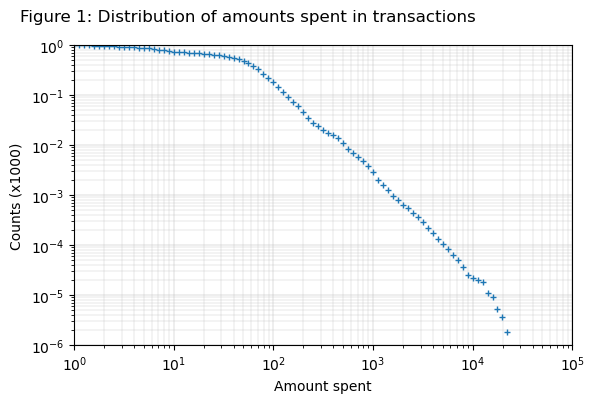

In [21]:
fig1, ax1 = plt.subplots(
    nrows=1, ncols=1, figsize=(6, 4), dpi=100,
    gridspec_kw={'left': 0.11, 'right': 0.94, 'top': 0.89, 'bottom': 0.14})
fig1.suptitle("Figure 1: Distribution of amounts spent in transactions",
              x=0.02, ha='left')

ax1.plot(amt_vals, amt_icdf, linestyle='', marker='+', markersize=5)

ax1.set_xscale('log')
ax1.set_xlim(1, 1e5)
ax1.set_xlabel('Amount spent')
ax1.set_yscale('log')
ax1.set_ylim(1e-6, 1)
ax1.set_ylabel('Counts (x1000)', labelpad=5)
ax1.grid(visible=True, linewidth=0.3)
ax1.grid(visible=True, which='minor', linewidth=0.2)


plt.show()

Figure 1 presents the distribution of transaction amounts. Most values are below
200.

### Correlation between non-categorical features

In [22]:
## Correlation matrix
df_ = df.loc[:, ['is_fraud'] + quant_vars + bool_vars]
corr = df_.corr().to_numpy()

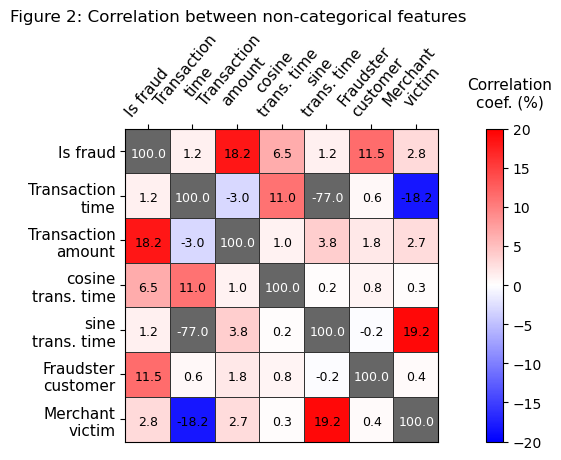

In [23]:
fig2, ax2 = plt.subplots(
    nrows=1, ncols=1, figsize=(5.6, 4.6), dpi=100,
    gridspec_kw={'left': 0.15, 'right': 0.86, 'top': 0.72, 'bottom': 0.04, 'wspace': 0.24})
cax2 = fig2.add_axes((0.87, 0.04, 0.03, 0.68))
fig2.suptitle("Figure 2: Correlation between non-categorical features",
              x=0.02, ha='left')


ax2.set_aspect('equal')
cmap2 = plt.get_cmap('bwr').copy()
cmap2.set_extremes(under='0.4', over='0.4')
heatmap = ax2.pcolormesh(corr[::-1]*100, cmap=cmap2, vmin=-20, vmax=20,
                             edgecolors='0.2', linewidth=0.5)

ax2.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ticklabels = ['Is fraud', 'Transaction\ntime', 'Transaction\namount',
              'cosine\ntrans. time', 'sine\ntrans. time',
              'Fraudster\ncustomer', 'Merchant\nvictim']
ax2.set_xticks(np.linspace(0.5, 6.5, 7), ticklabels, rotation=50,
               ha='center', fontsize=11)
ax2.set_yticks(np.linspace(6.5, 0.5, 7), ticklabels, rotation=0,
               ha='right', fontsize=11)

for (i, j), c in np.ndenumerate(corr[::-1]*100):
    ax2.text(j+0.52, i+0.45, f'{c:.1f}', color='w' if abs(c) > 50 else 'k',
             ha='center', va='center', fontsize=9)

pos = ax2.get_position().bounds
x, y = pos[0], pos[1] + pos[3]

fig2.colorbar(heatmap, cax=cax2, orientation="vertical", ticklocation="right")
cax2.text(1.4, 1.07, 'Correlation\ncoef. (%)', fontsize=11, ha='center',
          transform=cax2.transAxes)


plt.show()

Figure 2 shows the correlation matrix of non-categorical variables.
The linear correlation between fraud events and other variables is rather weak.

### Fraud probability vs day time

In [24]:
## Fraud probability vs month
df_ = df[['month', 'is_fraud']].assign(count=1).groupby('month').sum()

months = df_.index.to_numpy()
is_fraud = df_['is_fraud'].to_numpy()
count = df_['count'].to_numpy()

month_fprob = is_fraud / count
month_fprob_err = month_fprob * (1 - month_fprob) / np.sqrt(count)

In [25]:
## Fraud probability vs week day
df_ = df[['weekday', 'is_fraud']].assign(count=1).groupby('weekday').sum()

weekdays = df_.index.to_numpy()
is_fraud = df_['is_fraud'].to_numpy()
count = df_['count'].to_numpy()

day_fprob = is_fraud / count
day_fprob_err = day_fprob * (1 - day_fprob) / np.sqrt(count)

In [26]:
## Fraud probability vs hour
df_ = df[['day_time', 'is_fraud']]
df_ = df_.assign(count=1, hour=df_['day_time'] // 3600)
df_ = df_.groupby('hour').sum()

hours = df_.index.to_numpy()
is_fraud = df_['is_fraud'].to_numpy()
count = df_['count'].to_numpy()

hour_fprob = is_fraud / count
hour_fprob_err = hour_fprob * (1 - hour_fprob) / np.sqrt(count)

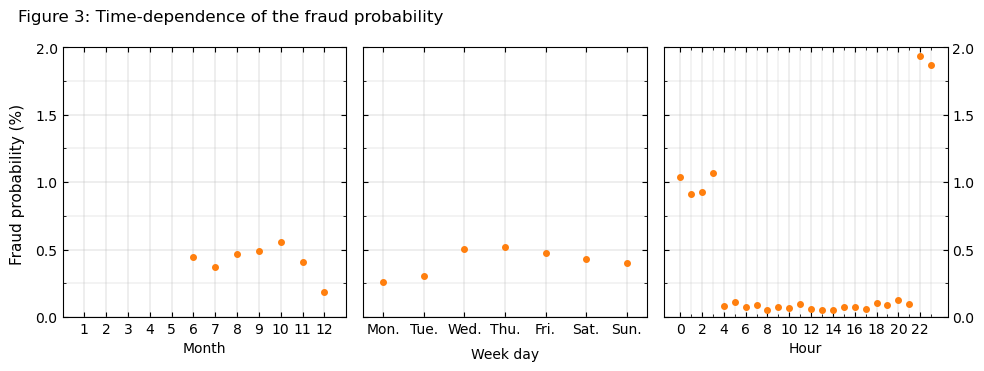

In [27]:
fig3, axs3 = plt.subplots(
    nrows=1, ncols=3, figsize=(10, 3.8), dpi=100, sharey=True,
    gridspec_kw={'left': 0.065, 'right': 0.95, 'top': 0.87, 'bottom': 0.16,
                 'wspace': 0.06})
fig3.suptitle("Figure 3: Time-dependence of the fraud probability",
              x=0.02, y=0.97, ha='left')

axs3[0].errorbar(months, 100*month_fprob, yerr=100*month_fprob_err,
                 color='tab:orange', linestyle='', marker='o', markersize=4)
axs3[0].tick_params(which='both', direction='in', top=True, right=True)
axs3[0].set_xlim(0, 13)
axs3[0].set_xticks(np.arange(1, 13))
axs3[0].set_xlabel('Month')
axs3[0].set_ylim(0, 2.)
axs3[0].set_yticks(np.linspace(0, 2, 5))
axs3[0].set_yticks(np.linspace(0.25, 1.75, 4), minor=True)
axs3[0].grid(visible=True, linewidth=0.3)
axs3[0].grid(visible=True, which='minor', linewidth=0.2)


axs3[1].errorbar(weekdays, 100*day_fprob, yerr=100*day_fprob_err,
                 color='tab:orange', linestyle='', marker='o', markersize=4)
axs3[1].tick_params(which='both', direction='in', top=True, right=True)
axs3[1].set_xlim(-0.5, 6.5)
axs3[1].set_xticks(np.arange(7),
                   ['Mon.', 'Tue.', 'Wed.', 'Thu.', 'Fri.', 'Sat.', 'Sun.'])
axs3[1].set_xlabel('Week day', labelpad=8)
axs3[1].grid(visible=True, linewidth=0.3)
axs3[1].grid(visible=True, which='minor', linewidth=0.2)


axs3[2].errorbar(hours, 100*hour_fprob, yerr=100*hour_fprob_err,
                 color='tab:orange', linestyle='', marker='o', markersize=4)
axs3[2].tick_params(which='both', direction='in', top=True,
                    right=True, labelright=True)
axs3[2].set_xlim(-1.5, 24.5)
axs3[2].set_xticks(np.arange(0, 24, 2))
axs3[2].set_xticks(np.arange(1, 24, 2), minor=True)
axs3[2].set_xlabel('Hour')
axs3[2].grid(visible=True, linewidth=0.3)
axs3[2].grid(visible=True, which='minor', linewidth=0.2)


fig3.text(0.02, 0.51, 'Fraud probability (%)', rotation=90, fontsize=11,
          ha='center', va='center')


plt.show()

Figure 3 presents
!!!

Strong non-linearity in the time dependence of the fraud -> choose non-linear model
such as decision tree.

### Joint probability distributions

!!!

In [28]:
## Transaction amounts and 1D histogram bins
amount = df['amt'].to_numpy()
amt_bins = np.linspace(0, 1800, 91)

## Day time observations and 1D histogram bins
day_time = df['day_time'].to_numpy()
time_bins = np.linspace(0, 86400, 49)

## distrib
yx = np.meshgrid(time_bins, amt_bins, indexing='ij')
time_amt_hist = np.histogram2d(day_time, amount, bins=[time_bins, amt_bins])[0]

## fraud probability
is_fraud = df['is_fraud'].to_numpy()
amt_j = np.digitize(amount, amt_bins) - 1
time_i = np.digitize(day_time, time_bins) - 1
fraud_prob = np.zeros((len(time_bins)-1, len(amt_bins)-1))
for i in range(len(time_bins)-1):
    idx_i = (time_i == i)
    for j in range(len(amt_bins)-1):
        fraud_prob[i, j] = np.mean(is_fraud[(amt_j == j) * idx_i])

c:\Users\netes\anaconda3\envs\main\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\netes\anaconda3\envs\main\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


C:\Users\netes\AppData\Local\Temp\ipykernel_16652\1633602256.py:10: RuntimeWarning: divide by zero encountered in log
  heatmap = axs4[0].pcolormesh(*yx, np.log(time_amt_hist),


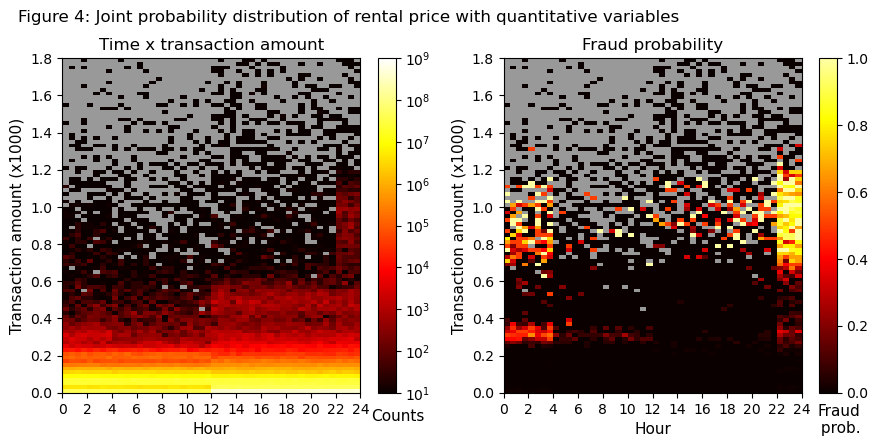

In [29]:
fig4, axs4 = plt.subplots(
    nrows=1, ncols=2, figsize=(8.8, 4.4), dpi=100, sharex=True,
    gridspec_kw={'left': 0.07, 'right': 0.91, 'top': 0.87, 'bottom': 0.11,
                 'wspace': 0.48})
fig4.suptitle("Figure 4: Joint probability distribution of rental price with quantitative variables",
              x=0.02, ha='left')

cmap4_0 = plt.get_cmap('hot').copy()
cmap4_0.set_extremes(bad='0.6', under=(0.0416, 0.0, 0.0, 1.0), over='0.6')
heatmap = axs4[0].pcolormesh(*yx, np.log(time_amt_hist),
                             cmap=cmap4_0, vmin=1, vmax=9)

axs4[0].set_xlim(0, np.max(time_bins))
axs4[0].set_xticks(np.linspace(0, 86400, 13), np.arange(0, 25, 2))
axs4[0].set_xlabel('Hour', fontsize=11)
axs4[0].set_ylim(0, np.max(amt_bins))
axs4[0].set_yticks(np.arange(0, 1900, 200),
                   [f'{x:.1f}' for x in np.linspace(0, 1.8, 10)])
axs4[0].set_ylabel('Transaction amount (x1000)', fontsize=11)
axs4[0].set_title('Time x transaction amount')

cax4_0 = fig4.add_axes((axs4[0]._position.get_points()[1, 0]+0.02,
                        axs4[0]._position.y0,
                        0.02,
                        axs4[0]._position.height))
fig4.colorbar(heatmap, cax=cax4_0, orientation="vertical", ticklocation="right")
cax4_0.set_yticks(np.linspace(1, 9, 9),
                  [rf'$10^{x}$' for x in np.arange(1, 10)])
cax4_0.text(1.1, -0.07, 'Counts', fontsize=11, ha='center', va='center',
            transform=cax4_0.transAxes)


cmap4_1 = plt.get_cmap('hot').copy()
cmap4_1.set_extremes(bad='0.6', under='0.7', over='0.5')
heatmap = axs4[1].pcolormesh(*yx, fraud_prob,
                             cmap=cmap4_1, vmin=0, vmax=1.1)
axs4[1].set_xlim(0, 86400)
axs4[1].set_xticks(np.linspace(0, 86400, 13), np.arange(0, 25, 2))
axs4[1].set_xlabel('Hour', fontsize=11)
axs4[1].set_yticks(np.arange(0, 1900, 200),
                   [f'{x:.1f}' for x in np.linspace(0, 1.8, 10)])
axs4[1].set_ylabel('Transaction amount (x1000)', fontsize=11)

cax4_1 = fig4.add_axes((axs4[1]._position.get_points()[1, 0]+0.02,
                        axs4[1]._position.y0,
                        0.02,
                        axs4[1]._position.height))
fig4.colorbar(heatmap, cax=cax4_1, orientation="vertical", ticklocation="right")
cax4_1.set_ylim(0, 1)
cax4_1.set_yticks(np.linspace(0, 1, 6))
cax4_1.text(1.1, -0.12, 'Fraud\n prob.', fontsize=11, ha='center',
            transform=cax4_1.transAxes)

axs4[1].set_title('Fraud probability')

plt.show()

Figure 4 presents

## <a id="preproc_utils"></a> Data preprocessing and utilities

!!!
Before moving on to model constructicat_vars = ['month', 'weekday']
bool_vars = ['cust_fraudster', 'merch_fraud_victim']
quant_vars = ['day_time', 'amt', 'cos_day_time', 'sin_day_time']on and training, we must first setup dataset
preprocessing and preparation.
We also introduce here some utilities relevant to model evaluation carried later on.


### Model evaluation utilities

We evaluate our model using the following metrics:
- The confusion matrix
- The precision
- The recall
- The F1 score


In [30]:
def eval_metrics(y_true: np.ndarray,
                 y_pred: np.ndarray,
                 print_cm: bool = False,
                 print_f1: bool = False)-> None:
    """
    Helper function that evaluates and return the relevant evaluation metrics:
        confusion matrix, precision, recall, F1-score
    """
    cm = confusion_matrix(y_true, y_pred)
    
    t = np.sum(cm, axis=1)[1]
    recall = (cm[1, 1] / t) if t != 0 else 1.
    t = np.sum(cm, axis=0)[1]
    prec = (cm[1, 1] / t) if t != 0 else 1.
    f1 = 2*prec*recall/(prec+recall)
    
    if print_cm:
        print("Confusion matrix\n", cm / np.sum(cm))
    if print_f1:
        print(f'Precision: {prec:.8}; recall: {recall:.8}')
        print(f'F1-score: {2*prec*recall/(prec+recall):.8}')
    
    return cm, prec, recall, f1

In [31]:
## Dataframe to hold the results
metric_names = ['precision', 'recall', 'F1-score']
index = pd.MultiIndex.from_product(
    [('Log reg', 'RF', 'HGB'), ('train', 'test')],
    names=['model', 'eval. set'])
evaluation_df = pd.DataFrame(
    np.full((6, 3), np.nan), index=index, columns=metric_names)

### Data preprocessing

The preprocessing of the dataset consists in the removal of outliers. We choose to remove those
observations corresponding to high rental price and mileage using a quantile range criterion.
More precisely, we discard those observations $i$ such that
$x_i < m + k(Q_{0.75} - Q_{0.25})$, where
$Q_{\alpha}$ is the $\alpha$-quantile and $k=6$ is an exclusion factor. We filter only
the values above, since the quantities are positive by definition.

We also setup here the preprocessing pipeline that will be part of the pricing models:
one-hot encoding of categorical variables and scaling of quantitative variables.

In [32]:
## data preparation
y = df['is_fraud']
X = df.drop(['is_fraud', 'merchant_id', 'customer_id'], axis=1)

## train-test split
X_tr, X_test, y_tr, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=1234)

## <a id="logreg"></a> Logistic regression

We first begin by training a baseline ridge regression model.


### Parameters optimization

We introduce L2 regularization to the model because of the large number of categorical features.
In order to select the appropriate value for the regularization parameter $\alpha$, we perform a grid search
with cross validation.

In [33]:
## column preprocessing
cat_vars = ['month', 'weekday', 'state']
bool_vars = ['cust_fraudster', 'merch_fraud_victim']
quant_vars = ['amt', 'cos_day_time', 'sin_day_time']

col_preproc = ColumnTransformer(
    [('cat_ohe',
      OneHotEncoder(drop=None, handle_unknown='infrequent_if_exist', min_frequency=0.005),
      cat_vars),
     ('bool_id', FunctionTransformer(feature_names_out='one-to-one'), bool_vars),
     ('quant_scaler', StandardScaler(), quant_vars)])

In [34]:
## Grid search of the regularization parameter with cross validation
scoring = ('precision',  'recall', 'f1')
Cs = np.logspace(-1, 4, 11)
logreg = LogisticRegression(penalty='l2')
clf = Pipeline(
    [('column_preprocessing', col_preproc),
     ('classifier', GridSearchCV(logreg, param_grid={'C': Cs},
                                 scoring=scoring, refit=False, cv=5))]
)
clf.fit(X_tr, y_tr)

Pipeline(steps=[('column_preprocessing',
                 ColumnTransformer(transformers=[('cat_ohe',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                min_frequency=0.005),
                                                  ['month', 'weekday',
                                                   'state']),
                                                 ('bool_id',
                                                  FunctionTransformer(feature_names_out='one-to-one'),
                                                  ['cust_fraudster',
                                                   'merch_fraud_victim']),
                                                 ('quant_scaler',
                                                  StandardScaler(),
                                                  ['amt', 'cos_day_time',
                                                   'sin_day_time'])])),
                ('classifier',
                 GridSearchCV(cv=5, estimator=LogisticRegression(),
                              param_grid={'C': array([1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03, 3.16227766e+03, 1.00000000e+04])},
                              refit=False,
                              scoring=('precision', 'recall', 'f1')))])

In [35]:
## Extract the relevant metrics
cv_res = clf['classifier'].cv_results_
prec = cv_res['mean_test_precision']
std_prec = cv_res['std_test_precision']
recall = cv_res['mean_test_recall']
std_recall = cv_res['std_test_recall']
f1 = cv_res['mean_test_f1']
std_f1 = cv_res['std_test_f1']

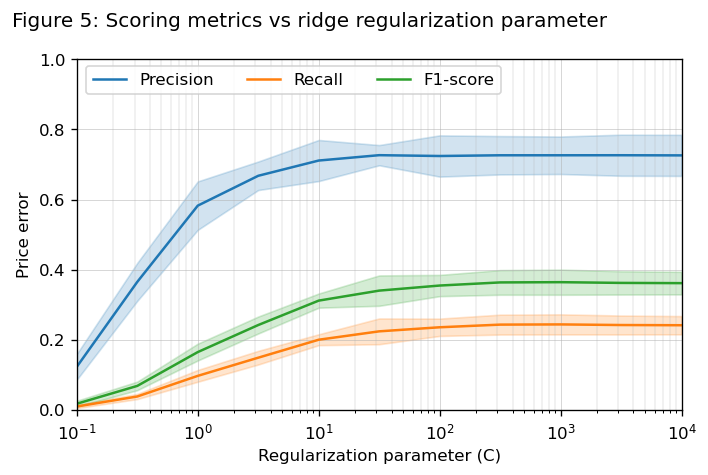

In [36]:
fig5, ax5 = plt.subplots(
    nrows=1, ncols=1, sharex=True, sharey=False, figsize=(6, 4), dpi=120,
    gridspec_kw={'left': 0.11, 'right': 0.95, 'top': 0.88, 'bottom': 0.15, 'wspace': 0.22})
fig5.suptitle("Figure 5: Scoring metrics vs ridge regularization parameter",
              x=0.02, ha='left')

ax5.plot(Cs, prec, color='C0', label='Precision')
ax5.fill_between(Cs, prec-std_prec, prec+std_prec,
                 color='C0', alpha=0.2)
ax5.plot(Cs, recall, color='C1', label='Recall')
ax5.fill_between(Cs, recall-std_recall, recall+std_recall,
                 color='C1', alpha=0.2)
ax5.plot(Cs, f1, color='C2', label='F1-score')
ax5.fill_between(Cs, f1-std_f1, f1+std_f1,
                 color='C2', alpha=0.2)

ax5.set_xscale('log')
ax5.set_xlim(1e-1, 1e4)
ax5.set_xticks(np.logspace(-1, 4, 6))
ax5.set_xticks(
    np.concatenate([np.linspace(10**i, 10**(i+1), 10) for i in range(-1, 4)]),
    minor=True)
ax5.set_xlabel('Regularization parameter (C)')
ax5.set_ylim(0, 1)
ax5.set_ylabel('Price error')
ax5.grid(visible=True, linewidth=0.3)
ax5.grid(visible=True, which='minor', linewidth=0.2)
ax5.legend(loc=(0.015, 0.9), ncols=3)


plt.show()

Figure 5 presents plots of our selected metrics as a function of the regularization parameter $\alpha$ of the ridge regression. The performance of the model starts to degrade for values of $\alpha$ above $\sim 100$.

### Model training and evaluation

According to the previous results, we retain a value $\alpha = 100$ for the regularization parameter of our ridge model.

In [37]:
## Complete pipeline
logreg_model = Pipeline([('column_preprocessing', col_preproc),
                        ('classifier', LogisticRegression(C=100))])

## train
logreg_model.fit(X_tr, y_tr)

## evaluate of train set
y_pred_tr = logreg_model.predict(X_tr)
_, prec, recall, f1 = eval_metrics(y_tr, y_pred_tr)
evaluation_df.iloc[0] = prec, recall, f1

## evaluate on test set
y_pred_test = logreg_model.predict(X_test)
_, prec, recall, f1 = eval_metrics(y_test, y_pred_test)
evaluation_df.iloc[1] = prec, recall, f1

In [38]:
evaluation_df.loc['Log reg']

,precision,recall,F1-score
eval. set,,,
train,0.734226,0.223776,0.343010
test,0.752137,0.205128,0.322344


The performance of the model is acceptable, with $R^2 \simeq 0.7$. The mean absolute error is about 12-13, significantly lower than the root mean squared error (17-19). This indicates that our model deals poorly with outliers. This can be caused by the aggregation of infrequent categories that may correspond large price differences (especially the car brand).

The metrics are significantly better for the train set than for the test set (300 vs 370 mean squared error), indicating an important overfitting of the model. Another possible explanation could be that the test set contains many observations with values in the infrequent categories, on which the model will fail to produce good results.

## <a id="random_forest"></a> Random forest

!!!

### Parameters optimization

!!!

No cos time here because trees capture well non-linear relationships

In [39]:
## column preprocessing
cat_vars = ['month', 'weekday', 'state']
bool_vars = ['cust_fraudster', 'merch_fraud_victim']
quant_vars = ['amt', 'day_time']
tree_col_preproc = ColumnTransformer(
    [('cat_oe', OrdinalEncoder(), cat_vars),
     ('id_', FunctionTransformer(None, feature_names_out='one-to-one'),
      bool_vars + quant_vars)])

In [40]:
## Grid search of the regularization parameter with cross validation
scoring = ('precision',  'recall', 'f1')
n_est_vals = np.arange(100, 1100, 600)
rfc = RandomForestClassifier(criterion='gini',
                             max_features=0.5,
                             bootstrap=True,
                             n_jobs=4,
                             random_state=1234)
clf = Pipeline(
    [('column_preprocessing', tree_col_preproc),
     ('classifier', GridSearchCV(rfc, param_grid={'n_estimators': n_est_vals},
                                 scoring=scoring, refit=False, cv=5))]
)
clf.fit(X_tr, y_tr)

Pipeline(steps=[('column_preprocessing',
                 ColumnTransformer(transformers=[('cat_oe', OrdinalEncoder(),
                                                  ['month', 'weekday',
                                                   'state']),
                                                 ('id_',
                                                  FunctionTransformer(feature_names_out='one-to-one'),
                                                  ['cust_fraudster',
                                                   'merch_fraud_victim', 'amt',
                                                   'day_time'])])),
                ('classifier',
                 GridSearchCV(cv=5,
                              estimator=RandomForestClassifier(max_features=0.5,
                                                               n_jobs=4,
                                                               random_state=1234),
                              param_grid={'n_estimators': array([100, 700])},
                              refit=False,
                              scoring=('precision', 'recall', 'f1')))])

In [41]:
## Extract the relevant metrics
cv_res = clf['classifier'].cv_results_
prec = cv_res['mean_test_precision']
std_prec = cv_res['std_test_precision']
recall = cv_res['mean_test_recall']
std_recall = cv_res['std_test_recall']
f1 = cv_res['mean_test_f1']
std_f1 = cv_res['std_test_f1']

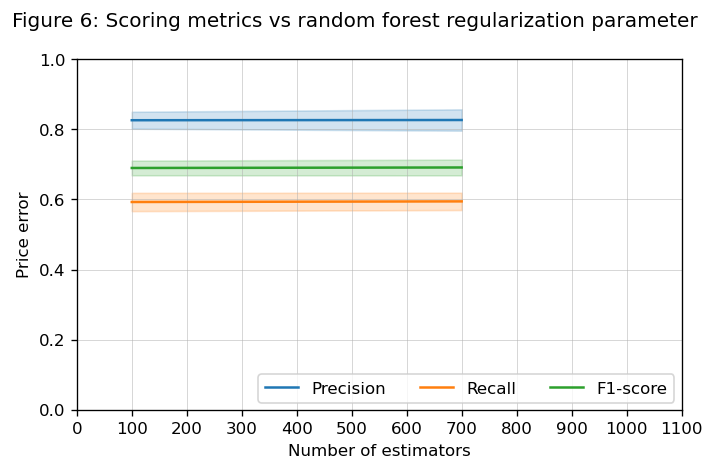

In [42]:
fig6, ax6 = plt.subplots(
    nrows=1, ncols=1, sharex=True, sharey=False, figsize=(6, 4), dpi=120,
    gridspec_kw={'left': 0.11, 'right': 0.95, 'top': 0.88, 'bottom': 0.15, 'wspace': 0.22})
fig6.suptitle("Figure 6: Scoring metrics vs random forest regularization parameter",
              x=0.02, ha='left')

ax6.plot(n_est_vals, prec, color='C0', label='Precision')
ax6.fill_between(n_est_vals, prec-std_prec, prec+std_prec,
                 color='C0', alpha=0.2)
ax6.plot(n_est_vals, recall, color='C1', label='Recall')
ax6.fill_between(n_est_vals, recall-std_recall, recall+std_recall,
                 color='C1', alpha=0.2)
ax6.plot(n_est_vals, f1, color='C2', label='F1-score')
ax6.fill_between(n_est_vals, f1-std_f1, f1+std_f1,
                 color='C2', alpha=0.2)

ax6.set_xlim(0, 1100)
ax6.set_xticks(np.arange(0, 1200, 100))
ax6.set_xlabel('Number of estimators')
ax6.set_ylim(0, 1)
ax6.set_ylabel('Price error')
ax6.grid(visible=True, linewidth=0.3)
ax6.grid(visible=True, which='minor', linewidth=0.2)
ax6.legend(loc=(0.3, 0.02), ncols=3)


plt.show()

Figure 6 presents plots of our selected metrics as a function of the number of estimators used with the gradient boosting regressor. The metrics reach an optimum for `n_estimators = 500`, which we retain for the model.

### Model training and evaluation

In [43]:
## Complete pipeline
randforest_model = Pipeline(
    [('column_preprocessing', tree_col_preproc),
     ('classifier', RandomForestClassifier(n_estimators=100,
                                           criterion='gini',
                                           max_features=0.5,
                                           bootstrap=True,
                                           n_jobs=4,
                                           random_state=1234))]
)

In [44]:
## train
randforest_model.fit(X_tr, y_tr)

## evaluate of train set
y_pred_tr = randforest_model.predict(X_tr)
_, prec, recall, f1 = eval_metrics(y_tr, y_pred_tr)
evaluation_df.iloc[2] = prec, recall, f1

## evaluate on test set
y_pred_test = randforest_model.predict(X_test)
_, prec, recall, f1 = eval_metrics(y_test, y_pred_test)
evaluation_df.iloc[3] = prec, recall, f1

In [45]:
evaluation_df.loc['RF']

,precision,recall,F1-score
eval. set,,,
train,1.00000,0.998834,0.999417
test,0.83612,0.582751,0.686813


The gradient boosting model is more performant than the simple ridge model. However, overfitting is still present, and even worse than for ridge regression. Nevertheless, the test set metrics are quite close to those obtained by cross-validation (see figure 6).

## <a id="hist_gradient_boosting"></a> Hist Gradient Boosting model

We complete the pricing models catalogue of our application by training
a gradient boosting regressor.


### Parameters optimization

In [46]:
## column preprocessing
cat_vars = ['month', 'weekday', 'state']
bool_vars = ['cust_fraudster', 'merch_fraud_victim']
quant_vars = ['amt', 'day_time']
tree_col_preproc = ColumnTransformer(
    [('cat_oe', OrdinalEncoder(), cat_vars),
     ('id_', FunctionTransformer(None, feature_names_out='one-to-one'),
      bool_vars + quant_vars)])

In [47]:
## Grid search of the regularization parameter with cross validation
scoring = ('precision',  'recall', 'f1')
max_iters = np.arange(100, 1001, 100)
clf = Pipeline(
    [('column_preprocessing', tree_col_preproc),
     ('classifier', GridSearchCV(HistGradientBoostingClassifier(random_state=1234),
                                 param_grid={'max_iter': max_iters},
                                 scoring=scoring, refit=False, cv=5))]
)
clf.fit(X_tr, y_tr)

Pipeline(steps=[('column_preprocessing',
                 ColumnTransformer(transformers=[('cat_oe', OrdinalEncoder(),
                                                  ['month', 'weekday',
                                                   'state']),
                                                 ('id_',
                                                  FunctionTransformer(feature_names_out='one-to-one'),
                                                  ['cust_fraudster',
                                                   'merch_fraud_victim', 'amt',
                                                   'day_time'])])),
                ('classifier',
                 GridSearchCV(cv=5,
                              estimator=HistGradientBoostingClassifier(random_state=1234),
                              param_grid={'max_iter': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000])},
                              refit=False,
                              scoring=('precision', 'recall', 'f1')))])

In [48]:
## Extract the relevant metrics
cv_res = clf['classifier'].cv_results_
prec = cv_res['mean_test_precision']
std_prec = cv_res['std_test_precision']
recall = cv_res['mean_test_recall']
std_recall = cv_res['std_test_recall']
f1 = cv_res['mean_test_f1']
std_f1 = cv_res['std_test_f1']

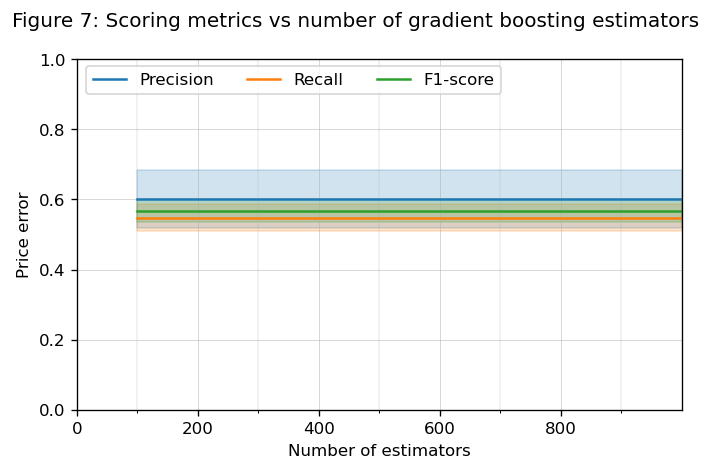

In [49]:
fig7, ax7 = plt.subplots(
    nrows=1, ncols=1, sharex=True, sharey=False, figsize=(6, 4), dpi=120,
    gridspec_kw={'left': 0.11, 'right': 0.95, 'top': 0.88, 'bottom': 0.15, 'wspace': 0.22})
fig7.suptitle("Figure 7: Scoring metrics vs number of gradient boosting estimators",
              x=0.02, ha='left')


ax7.plot(max_iters, prec, color='C0', label='Precision')
ax7.fill_between(max_iters, prec-std_prec, prec+std_prec,
                 color='C0', alpha=0.2)
ax7.plot(max_iters, recall, color='C1', label='Recall')
ax7.fill_between(max_iters, recall-std_recall, recall+std_recall,
                 color='C1', alpha=0.2)
ax7.plot(max_iters, f1, color='C2', label='F1-score')
ax7.fill_between(max_iters, f1-std_f1, f1+std_f1,
                 color='C2', alpha=0.2)
ax7.set_xlim(0, 1000)
ax7.set_xticks(np.arange(0, 1000, 200))
ax7.set_xticks(np.arange(100, 1000, 200), minor=True)
ax7.set_xlabel('Number of estimators')
ax7.set_ylim(0, 1)
ax7.set_ylabel('Price error')
ax7.grid(visible=True, linewidth=0.3)
ax7.grid(visible=True, which='minor', linewidth=0.2)
ax7.legend(loc=(0.015, 0.9), ncols=3)


plt.show()

!!!
Figure 7 presents plots of our selected metrics as a function of the number of estimators
used with the gradient boosting regressor. The metrics reach an optimum for `n_estimators = 500`,
which we retain for the model.

### Model training and evaluation

In [50]:
## Complete pipeline
hgb_model = Pipeline(
    [('column_preprocessing', tree_col_preproc),
     ('regressor', HistGradientBoostingClassifier(max_iter=100,
                                                  random_state=1234))]
)

In [51]:
## train
hgb_model.fit(X_tr, y_tr)

## evaluate of train set
y_pred_tr = hgb_model.predict(X_tr)
_, prec, recall, f1 = eval_metrics(y_tr, y_pred_tr)
evaluation_df.iloc[4] = prec, recall, f1

## evaluate on test set
y_pred_test = hgb_model.predict(X_test)
_, prec, recall, f1 = eval_metrics(y_test, y_pred_test)
evaluation_df.iloc[5] = prec, recall, f1

In [52]:
evaluation_df.loc['HGB']

,precision,recall,F1-score
eval. set,,,
train,0.655878,0.578671,0.614861
test,0.630319,0.552448,0.588820


!!!
The gradient boosting model is more performant than the simple ridge model.
However, overfitting is still present, and even worse than for ridge regression.
Nevertheless, the test set metrics are quite close
to those obtained by cross-validation (see figure 6).

## <a id="summary"></a> Summary

In [ ]:
evaluation_df